# Coordinated Spiking Model

Install required packages

In [1]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation

## Single-neuron

Initialize parameters

In [321]:
def initialize_params_single(dt, iterations, gamma):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike train
    o = np.zeros(iterations)

    # voltage
    voltage = np.zeros(iterations)

    # threshold
    T = (gamma**2) / 2

    # spike times
    spike = []
    t_spike = []
    
    return (t, x_est, o, voltage, T, spike, t_spike) 

Create time varying signal

In [322]:
def TVS_single():
    
    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 100
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [323]:
def run_single():
    for t in range(1, iterations):

        # udpate input estimate
        dxestdt = -x_est[t - 1] + gamma * o[t - 1]
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltage
        dVdt = -voltage[t - 1] + gamma * c[t - 1] - o[t - 1] * (gamma ** 2)
        voltage[t] = voltage[t - 1] + dt * dVdt

        # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

            # save spike times
            spike.append(1)
            t_spike.append(t)

Plot results (input + input estimate, voltage, spikes)

In [324]:
def plot_single():
    plots = 3
    pl.subplots(plots, 1, figsize=(8, 4))

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$')
    pl.plot(x_est, label=r'$\hat{x}$')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    pl.subplot(plots, 1, 2)
    pl.plot(voltage, 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')
    pl.yticks([])
    pl.xticks([])

    pl.subplot(plots, 1, 3)
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xlabel('time')

Runs de simulation

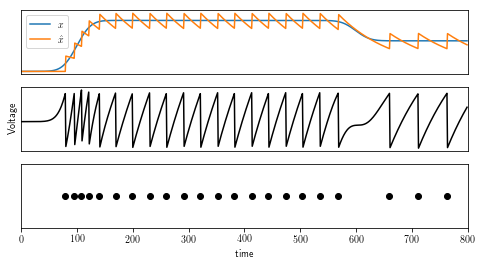

In [325]:
dt = 0.01
iterations = 800
gamma = 1.5

t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
x,c = TVS_single()
run_single()
plot_single()

## $\textit{N}$-neurons (homogeneous network)

Initialize parameters

In [8]:
def initialize_params_homogeneous(N, dt, iterations, gamma, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    weight = np.ones((1, N)) * gamma

    # threshold
    T = (gamma**2) / 2 + mu/2

    return (t, x_est, o, voltage, weight, T) 

Create time varying signal

In [4]:
def TVS_homogeneous():

    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

In [5]:
def run_homogeneous():
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(weight, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -voltage[:, t - 1] + weight * c[t - 1] - np.dot((weight ** 2) + mu, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        above_threshold = np.where(voltage[:, t] > T)

        # reset neuron when threshold is exceeded
        if len(above_threshold[0]) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.randint(0, len(above_threshold[0]))

            # update spikes
            o[spike_neuron, t] = 1/dt

Plot results

In [6]:
def plot_homogeneous():
    plots = (2 * N) + 1
    pl.subplots(plots, 1, figsize=(8, 12))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    counter = 2

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$')
    pl.plot(x_est, label=r'$\hat{x}$')
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    for i in range(N):

        neuron = i + 1

        pl.subplot(plots, 1, counter)
        pl.plot(voltage[i], 'k')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.title('Neuron %i' %neuron)
        pl.yticks([])
        pl.xticks([])

        counter = counter + 1

        # extract spike times
        spike = []
        t_spike = []

        for s in range(1, iterations):
            if o[i, s] > 0:
                spike.append(1)
                t_spike.append(s)

        # plot spike times
        pl.subplot(plots, 1, counter)
        pl.scatter(t_spike, spike, c='k')
        pl.xlim(0, iterations)
        pl.yticks([])
        pl.xticks([])

        counter = counter + 1

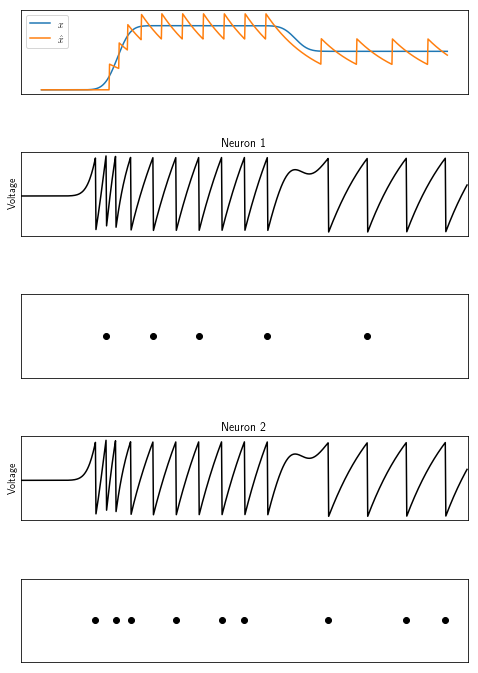

In [15]:
N = 2
dt = 0.01
iterations = 800
gamma = 2
mu = 0 #regularization

t, x_est, o, voltage, weight, T = initialize_params_homogeneous(N, dt, iterations, gamma, mu)
x,c = TVS_homogeneous()
run_homogeneous()
plot_homogeneous()

## $\textit{N}$-neurons (heterogeneous network)

Initialize parameters

In [357]:
def initialize_params_heterogeneous(N, dt, iterations, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    weight = np.random.uniform(1, 4, size=(1,N))

    # threshold
    T = (weight ** 2)/2 + mu/2
    
    return (t, x_est, o, voltage, weight, T, spike, t_spike)

Create time varying signal

In [362]:
def TVS_heterogeneous():

    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

In [359]:
def run_heterogeneous():
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(weight, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -voltage[:, t - 1] + weight * c[t - 1] - np.dot((weight ** 2) + mu, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        above_threshold = []

        for i in range(N): 
            if voltage[i, t] > T[0][i]:
                above_threshold.append(i)

        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.randint(0, len(above_threshold))

            # update spikes
            o[spike_neuron, t] = 1/dt

Plot results

In [360]:
def plot_heterogeneous():
    plots = (2 * N) + 1
    pl.subplots(plots, 1, figsize=(8, 12))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    counter = 2

    pl.subplot(plots, 1, 1)
    pl.plot(smooth, label=r'$x$')
    pl.plot(x_est, label=r'$\hat{x}$')
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    for i in range(N):

        neuron = i + 1

        pl.subplot(plots, 1, counter)
        pl.plot(voltage[i], 'k')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.title('Neuron %i' %neuron)
        pl.yticks([])
        #pl.xticks([])

        counter = counter + 1

        # extract spike times
        spike = []
        t_spike = []

        for s in range(1, iterations):
            if o[i, s] > 0:
                spike.append(1)
                t_spike.append(s)

        # plot spike times
        pl.subplot(plots, 1, counter)
        pl.scatter(t_spike, spike, c='k')
        pl.xlim(0, iterations)
        pl.yticks([])
        pl.xticks([])

        counter = counter + 1

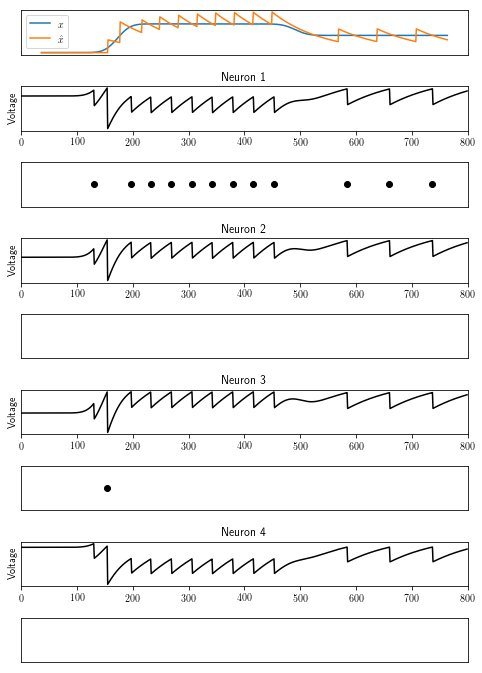

In [364]:
N = 4
dt = 0.01
iterations = 800
mu = 0.1 #regularization

t, x_est, o, voltage, weight, T, spike, t_spike = initialize_params_heterogeneous(N, dt, iterations, mu)
x,c = TVS_heterogeneous()
run_heterogeneous()
plot_heterogeneous()